Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

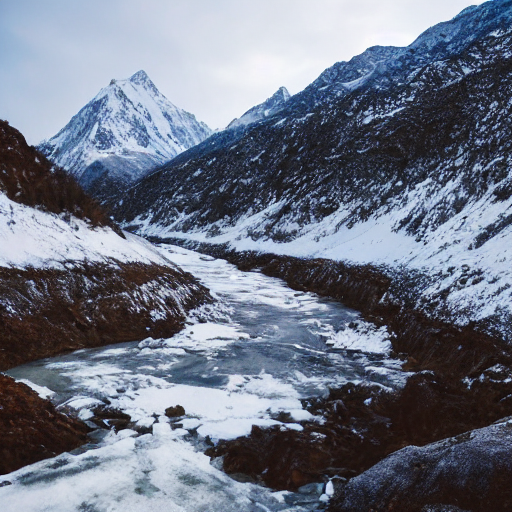

Caption: A river flowing inbetween two snow-capped mountains


In [6]:
# Install required libraries
!pip install diffusers transformers accelerate --quiet

# Import necessary libraries
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image

# Load the Stable Diffusion pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe.to(device)

# Define the prompt for image generation
prompt = "A river flowing inbetween two snow-capped mountains"

# Generate the image
image = pipe(prompt).images[0]

# Save and display the image
image_path = "generated_image.png"
image.save(image_path)

# Display the image in the notebook
from IPython.display import Image as IPImage, display
display(IPImage(image_path))

# Add a caption to the displayed image
print(f"Caption: {prompt}")

In [3]:
# Import necessary libraries
from diffusers import StableDiffusionPipeline
import torch
from torchvision.models import inception_v3
import torchvision.transforms as T
import torch.nn.functional as F
from scipy.linalg import sqrtm
import numpy as np
from PIL import Image
from tqdm import tqdm

# Load the Stable Diffusion pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe.to(device)

# Preprocessing function for images
def preprocess_image(image, device):
    transform = T.Compose([
        T.Resize((299, 299)),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    return transform(image).unsqueeze(0).to(device)

# Generate multiple images with Stable Diffusion
def generate_images(pipe, prompts, device):
    generated_images = []
    for prompt in tqdm(prompts, desc="Generating Images"):
        image = pipe(prompt).images[0]
        generated_images.append(preprocess_image(image, device))
    return torch.cat(generated_images)

# Feature extraction using InceptionV3
def get_inception_features(images, device):
    model = inception_v3(pretrained=True, transform_input=False).eval().to(device)
    with torch.no_grad():
        return model(images).cpu().numpy()

# Calculate FID
def calculate_fid(real_features, fake_features):
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)
    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real @ sigma_fake)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

# Calculate Inception Score
def calculate_inception_score(fake_images, splits=10):
    model = inception_v3(pretrained=True, transform_input=False).eval().to(fake_images.device)
    upsample = T.Resize((299, 299))
    preds = []
    with torch.no_grad():
        for img in fake_images:
            img = upsample(img.unsqueeze(0))
            logits = model(img)
            p = F.softmax(logits, dim=1)
            preds.append(p)
    preds = torch.cat(preds)
    split_scores = []
    for i in range(splits):
        part = preds[i * len(preds) // splits:(i + 1) * len(preds) // splits]
        p_y = part.mean(0)
        kl_div = part * (torch.log(part) - torch.log(p_y))
        kl_div = kl_div.sum(1)
        split_scores.append(torch.exp(kl_div.mean()))
    return torch.tensor(split_scores).mean().item(), torch.tensor(split_scores).std().item()

# Evaluation process
def evaluate_model(pipe, real_images, prompts, device):
    # Generate fake images
    fake_images = generate_images(pipe, prompts, device)
    # Extract features
    real_features = get_inception_features(real_images, device)
    fake_features = get_inception_features(fake_images, device)
    # Calculate FID
    fid = calculate_fid(real_features, fake_features)
    print(f"FID Score: {fid:.4f}")
    # Calculate IS
    is_score, is_std = calculate_inception_score(fake_images)
    print(f"Inception Score: {is_score:.4f} ± {is_std:.4f}")

# Real images (replace with actual real image dataset)
# Ensure real_images are on the correct device
real_images = torch.randn(10, 3, 299, 299).to(device)  # Moved to device

# Prompts for generating fake images
prompts = [
    "A serene mountain landscape with a crystal-clear lake reflecting the sky, in ultra-realistic detail.",
    "A dense forest with sunlight streaming through the trees, painted in photorealistic style.",
    "A bustling city skyline at night, with lights twinkling in every direction.",
    "A peaceful beach with turquoise waters and white sand under a clear blue sky.",
    "A majestic lion standing on a rock in the African savannah, looking at the horizon.",
    "A futuristic city with flying cars and neon lights, in a cyberpunk setting.",
    "A tranquil snowy village in the mountains, with smoke rising from chimneys.",
    "A close-up of a vibrant, blooming flower with dew drops on the petals.",
    "A vast desert with rolling sand dunes under a setting sun.",
    "A dramatic volcanic eruption with glowing lava and smoke rising into the sky."
]

# Evaluate the model
evaluate_model(pipe, real_images, prompts, device)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating Images:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1/10 [00:14<02:10, 14.53s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2/10 [00:27<01:50, 13.75s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3/10 [00:40<01:34, 13.50s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4/10 [00:54<01:20, 13.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images:  50%|█████     | 5/10 [01:07<01:06, 13.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images:  60%|██████    | 6/10 [01:20<00:53, 13.28s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images:  70%|███████   | 7/10 [01:33<00:39, 13.27s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8/10 [01:47<00:26, 13.27s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images:  90%|█████████ | 9/10 [02:00<00:13, 13.25s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 100%|██████████| 10/10 [02:13<00:00, 13.35s/it]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 231MB/s] 


FID Score: 2649.9301
Inception Score: 1.0000 ± 0.0000


In [2]:
# Install required libraries
!pip install diffusers transformers accelerate --quiet
!pip install scipy torchvision numpy --quiet